In [185]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from prophet import Prophet
from sklearn.metrics import mean_absolute_error, mean_squared_error
import plotly.express as px
import pickle 

import warnings

# Filter out TqdmWarning and FutureWarning
warnings.filterwarnings("ignore", category=UserWarning, module="tqdm")
warnings.filterwarnings("ignore", category=FutureWarning, module="prophet")


# Importing f10.7 (sfu) 

solar flux units
Unlike many solar indices, the F10.7 radio flux can easily be measured reliably on a day-to-day basis from the Earth's surface, in all types of weather. Reported in “solar flux units”, (s.f.u.), the F10.7 can vary from below 50 s.f.u., to above 300 s.f.u., over the course of a solar cycle.

In this dataset, F10.7 logs are displayed as monthly means, but are recodred daily at a higher frequency (every 15 seconds) by GOES sattelite's instruments

The below prediction is far from being perfect and might be correct in a short timeframe (12month), but then be off compared to NASA's & NOAA's predictions.

In [186]:
solar_cycle_f10_7 = pd.read_csv('../data/solar_cycle.csv')

columns_to_drop = ['ssn','smoothed_ssn', 'observed_swpc_ssn', 'smoothed_swpc_ssn', 'smoothed_f10.7']
solar_cycle_f10_7 = solar_cycle_f10_7.drop(columns=columns_to_drop)

# Convert 'time_tag' column to datetime 
solar_cycle_f10_7['time_tag'] = pd.to_datetime(solar_cycle_f10_7['time_tag'])

# Filter the DataFrame to keep rows with 'time_tag' >= '2005-01-01' where NOAA started capturing f10.7  
solar_cycle_f10_7= solar_cycle_f10_7[solar_cycle_f10_7['time_tag'] >= '2005-01-01']

In [187]:
solar_cycle_f10_7


,time_tag,f10.7
3072,2005-01-01,102.86
3073,2005-02-01,97.30
3074,2005-03-01,90.04
3075,2005-04-01,85.92
3076,2005-05-01,101.65
...,...,...
3295,2023-08-01,153.92
3296,2023-09-01,155.74
3297,2023-10-01,141.59
3298,2023-11-01,154.36


In [188]:
# Rename columns to match Prophet's requirements (ds for time and y for target)
solar_cycle_f10_7.rename(columns={'time_tag': 'ds', 'f10.7': 'y'}, inplace=True)

# Sort the DataFrame by 'ds' in chronological order - was already, but just in case
solar_cycle_f10_7 = solar_cycle_f10_7.sort_values(by='ds')

# plot the full dataframe, to see solar cycle's pattern (more or less 11 years)
fig = px.line(solar_cycle_f10_7, x='ds', y='y', title='Solar Cycle Data - sfu Xray emissions')
fig.update_xaxes(title_text='Time')
fig.update_yaxes(title_text='f10.7 Xray emissions')
fig.update_layout(xaxis=dict(tickangle=-45), showlegend=True)
fig.show()

# Reusing SSN prophet's model to predict next 5 years

16:15:04 - cmdstanpy - INFO - Chain [1] start processing


16:15:04 - cmdstanpy - INFO - Chain [1] done processing


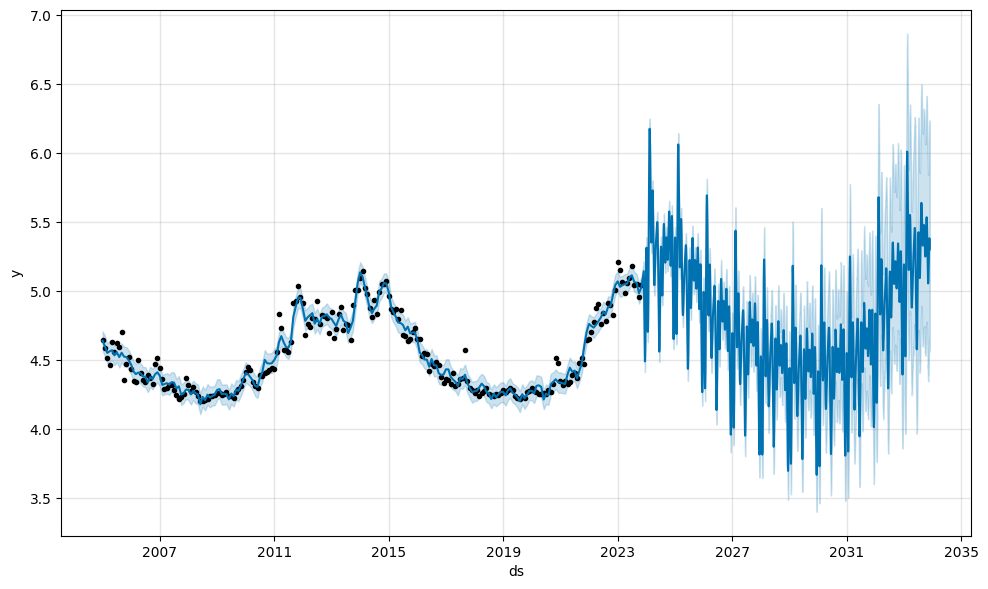

In [189]:
#ORIGINAL ASSUMTION 

# NOTE - Observed seasonality of the sun is between 10.2 to 11.5 on average, i tried multiple comnbination to land on these figures


# model = Prophet(
#     n_changepoints=150,  # Adjust growth type  
#     seasonality_mode='multiplicative',
#     changepoint_prior_scale=0.5,  # Adjust changepoint_prior_scale
#     holidays_prior_scale=0.2
# ).add_seasonality(name="11_years", period=10.38*365, fourier_order=20) #fourier_order=20


#AFTER HYPERPARAMETERS TUNING
model = Prophet(
    n_changepoints=150,  # Adjust growth type  
    seasonality_mode='multiplicative',
    changepoint_prior_scale=0.3,  # Adjust changepoint_prior_scale
    holidays_prior_scale=0.3
).add_seasonality(name="11_years", period=10.15*365, fourier_order=20) #fourier_order=20

#Best Parameters: {'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.3, 'n_changepoints': 150, 'seasonality_mode': 'multiplicative'}
#Best MAE: 49.98500456124057



# Rename the columns to match the required format
prophet_df = solar_cycle_f10_7.copy()

# Log transform the 'y' column
prophet_df["y"] = np.log1p(prophet_df["y"])

# Fit the model
model.fit(prophet_df)

# Create a dataframe for future predictions (next 10 years)
future = model.make_future_dataframe(periods=365*10, freq='D')

# Make predictions
forecast = model.predict(future)

# Plot the results (you can customize the plotting as needed)
fig = model.plot(forecast)
plt.show()

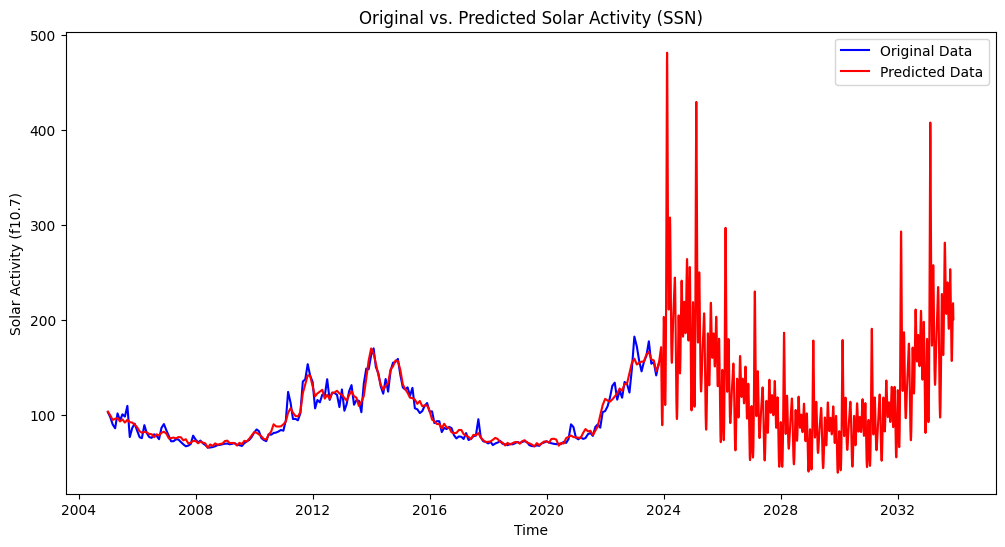

In [190]:
# Apply the exponential function to revert the log transformation
forecast['yhat'] = np.exp(forecast['yhat'])

# Extract the predicted values of 'ds' and the reverted 'yhat' from the forecast dataframe
predicted_y = forecast[['ds', 'yhat']]

# Plot the predicted values alongside the original 'y' values
plt.figure(figsize=(12, 6))
plt.plot(solar_cycle_f10_7['ds'], solar_cycle_f10_7['y'], label='Original Data', color='blue')
plt.plot(predicted_y['ds'], predicted_y['yhat'], label='Predicted Data', color='red')
plt.title('Original vs. Predicted Solar Activity (SSN)')
plt.xlabel('Time')
plt.ylabel('Solar Activity (f10.7)')
plt.legend()
plt.show()

# train/split

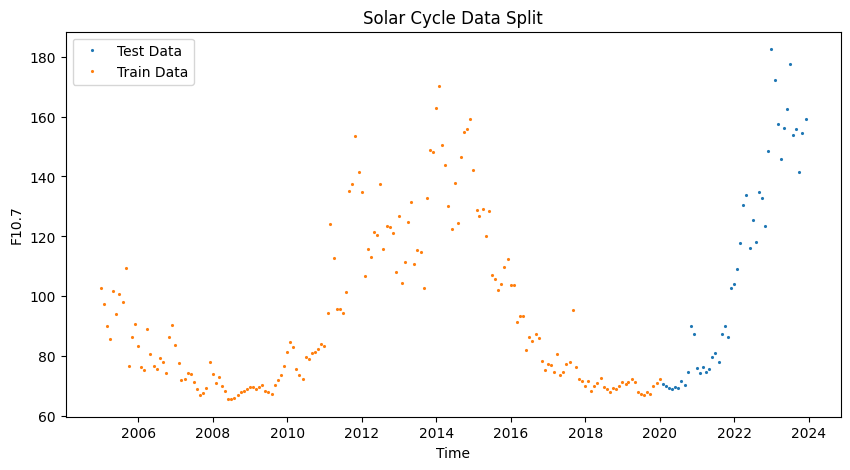

In [191]:
# Define the split date
split_date = '2020-01-01'

# Create train and test DataFrames based on the split date
solar_cycle_f10_7_train = solar_cycle_f10_7[solar_cycle_f10_7['ds'] <= split_date].copy()
solar_cycle_f10_7_test = solar_cycle_f10_7[solar_cycle_f10_7['ds'] > split_date].copy()

import matplotlib.pyplot as plt

# Plot train and test data to visualize the split
plt.figure(figsize=(10, 5))
plt.plot(solar_cycle_f10_7_test['ds'], solar_cycle_f10_7_test['y'], label='Test Data', linestyle='', marker='.', ms=2.5)  
plt.plot(solar_cycle_f10_7_train['ds'], solar_cycle_f10_7_train['y'], label='Train Data', linestyle='', marker='.', ms=2.5)  
plt.title('Solar Cycle Data Split')
plt.xlabel('Time')
plt.ylabel('F10.7')
plt.legend()
plt.show()

In [192]:
# reusing above model on train 

test_model = Prophet(
    growth='linear',  # Adjust growth type
    interval_width=0.95,  # Wider prediction intervals
   # seasonality_mode='multiplicative',
    changepoint_prior_scale=0.01  # Adjust changepoint_prior_scale
).add_seasonality(name="11_years", period=10.83*365, fourier_order=20) #fourier_order=20

test_model.fit(solar_cycle_f10_7_train)

16:15:05 - cmdstanpy - INFO - Chain [1] start processing
16:15:05 - cmdstanpy - INFO - Chain [1] done processing


In [193]:

solar_cycle_f10_7_predict = test_model.predict(solar_cycle_f10_7_test)

In [194]:
solar_cycle_f10_7_predict.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,11_years,11_years_lower,11_years_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2020-02-01,98.073450,57.355340,75.812151,98.073450,98.073450,-29.456946,-29.456946,-29.456946,-31.536562,-31.536562,-31.536562,-2.079616,-2.079616,-2.079616,0.0,0.0,0.0,66.536887
1,2020-03-01,98.067486,59.471274,78.655921,98.067486,98.067486,-28.436999,-28.436999,-28.436999,-29.688229,-29.688229,-29.688229,-1.251230,-1.251230,-1.251230,0.0,0.0,0.0,68.379257
2,2020-04-01,98.061111,61.908534,80.936072,98.061111,98.061111,-27.481707,-27.481707,-27.481707,-26.921071,-26.921071,-26.921071,0.560636,0.560636,0.560636,0.0,0.0,0.0,71.140040
3,2020-05-01,98.054942,61.757060,80.418931,98.054941,98.054942,-27.836109,-27.836109,-27.836109,-27.152677,-27.152677,-27.152677,0.683432,0.683432,0.683432,0.0,0.0,0.0,70.902264
4,2020-06-01,98.048567,56.306161,74.616122,98.048566,98.048567,-29.606774,-29.606774,-29.606774,-32.604607,-32.604607,-32.604607,-2.997833,-2.997833,-2.997833,0.0,0.0,0.0,65.443960


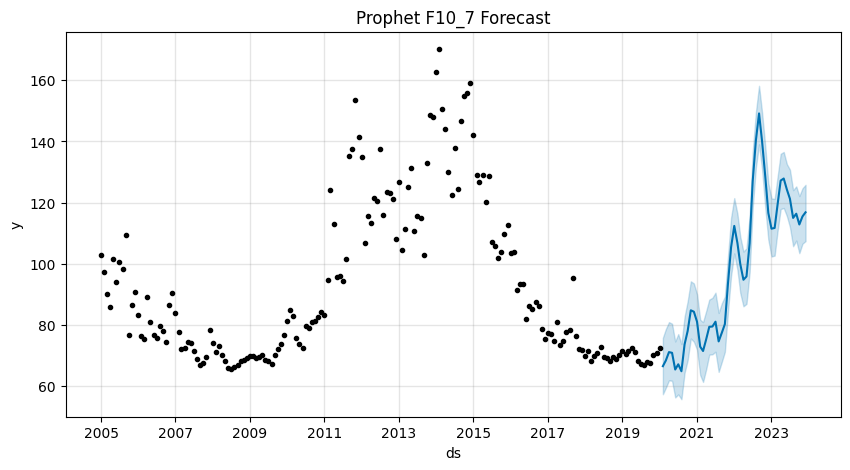

In [195]:
fig, ax = plt.subplots(figsize=(10, 5))
fig = test_model.plot(solar_cycle_f10_7_predict, ax=ax)
ax.set_title('Prophet F10_7 Forecast')
plt.show()

    # The black points represent the data points used to train the test_model
    # The blue line represents the forecast
    # The light blue area represents the confidence intervals.

In [196]:
import functions as fun
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Calculate Mean Absolute Error (MAE) and Mean Squared Error (MSE) for the test period
mae = mean_absolute_error(solar_cycle_f10_7_test['y'], solar_cycle_f10_7_predict['yhat'])
mse = mean_squared_error(solar_cycle_f10_7_test['y'], solar_cycle_f10_7_predict['yhat'])
#mape = fun.mean_absolute_percentage_error(solar_cycle_f10_7_test['y'], solar_cycle_f10_7_predict['yhat'])

print(f'Mean Absolute Error (MAE): {mae:.2f}')
print(f'Mean Squared Error (MSE): {mse:.2f}')
# print(f'Mean absolute precentage error (MAPE): {mape:.2f}')

Mean Absolute Error (MAE): 16.59
Mean Squared Error (MSE): 609.07


# Fine tuning with hyper-parameters search

In [198]:
# from sklearn.model_selection import ParameterGrid  
# import random

# # Define your parameter grid
# params_grid = {
#     'seasonality_mode': ['multiplicative', 'additive'],
#     'changepoint_prior_scale': [0.1, 0.2, 0.3, 0.4, 0.5],
#     'holidays_prior_scale': [0.1, 0.2, 0.3, 0.4, 0.5],
#     'n_changepoints': [100, 150, 200]
# }

# grid = ParameterGrid(params_grid)
# cnt = 0
# for p in grid:
#     cnt = cnt + 1

# print('Total Possible Models', cnt)

# # Initialize a DataFrame to store the results
# results = []

# strt = '2020-01-01'
# end = '2023-12-01'

# for p in grid:
#     print(p)
#     random.seed(0)

#     # Create and fit the Prophet model with the current parameters
#     model = Prophet(
#         changepoint_prior_scale=p['changepoint_prior_scale'],
#         holidays_prior_scale=p['holidays_prior_scale'],
#         n_changepoints=p['n_changepoints'],
#         seasonality_mode=p['seasonality_mode'],
#         weekly_seasonality=True,
#         daily_seasonality=True,
#         yearly_seasonality=True
#     )
#     model.fit(solar_cycle_f10_7_train)

#     # Make predictions for the test period
#     future = model.make_future_dataframe(periods=len(solar_cycle_f10_7_test), freq='M')
#     forecast = model.predict(future)

#     # Extract the relevant rows from the forecast for the test period
#     test = forecast.loc[(forecast['ds'] > strt) & (forecast['ds'] <= end)].copy()  # Ensure 'test' only contains relevant rows

#     # Filter 'solar_cycle_f10_7_test' to match the length of 'test'
#     solar_cycle_f10_7_test = solar_cycle_f10_7_test.iloc[:len(test)].copy()

#     # Calculate the Mean Absolute Error (MAE) for the test period
#     MAE = mean_absolute_error(solar_cycle_f10_7_test['y'], test['yhat'])

#     print('Mean Absolute Error (MAE):', MAE)

#     # Append the results to the results list
#     results.append({'MAE': MAE, 'Parameters': p})

# # Create a DataFrame from the results list
# model_parameters = pd.DataFrame(results)

# # Sort the results by MAE in ascending order
# model_parameters = model_parameters.sort_values(by='MAE')

# # Print the best parameters and corresponding MAE
# best_params = model_parameters.iloc[0]['Parameters']
# best_mae = model_parameters.iloc[0]['MAE']
# print('Best Parameters:', best_params)
# print('Best MAE:', best_mae)

In [199]:
with open('../models/prophet/prophet_model_solar_cycles_f10_7.pkl', 'wb') as model_file:
    pickle.dump(model, model_file)

# Converting outputed forecast into a monthly frequency, reseting the index to fit other predictions 

In [200]:
# Filter rows before 2023-12-31
forecast = forecast[forecast['ds'] > '2023-12-31']

# Filter columns to keep only 'yhat', 'yhat_lower', and 'yhat_upper'
forecast = forecast[['ds', 'yhat']]

# Rename the columns with "prophet_" prefix
forecast.rename(columns={'yhat': 'prophet_f10_7'}, inplace=True)

# Reset the index
forecast.reset_index(drop=True, inplace=True)

In [201]:
forecast

,ds,prophet_f10_7
0,2024-01-01,193.107482
1,2024-01-02,198.377796
2,2024-01-03,201.819281
3,2024-01-04,203.260139
4,2024-01-05,202.641329
...,...,...
3615,2033-11-24,217.688350
3616,2033-11-25,216.017604
3617,2033-11-26,212.584122
3618,2033-11-27,207.452059


In [202]:
prophet_10y_f10_7forecast = fun.group_and_average_by_month(forecast, 'ds')

#reseting the date column for future comparison with SARIMA

prophet_10y_f10_7forecast['ds'] = prophet_10y_f10_7forecast['ds'].dt.strftime('%Y-%m-01')

display(prophet_10y_f10_7forecast)

,ds,prophet_f10_7
0,2024-01-01,153.804489
1,2024-02-01,358.812411
2,2024-03-01,258.078365
3,2024-04-01,176.964129
4,2024-05-01,224.229759
...,...,...
114,2033-07-01,193.184957
115,2033-08-01,243.220657
116,2033-09-01,219.883398
117,2033-10-01,220.837190


In [203]:
#saving the cleaned and re-indexed dataframe as a CSV for further use
prophet_10y_f10_7forecast.to_csv('../data/prophet_10Y__f10_7_forecast.csv', index=False)